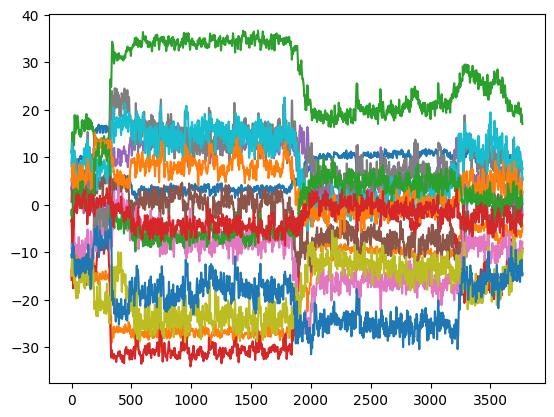

In [88]:
import os
import numpy as np
from scipy.io.wavfile import read as waveread
import pysptk
from functools import cached_property
import librosa

import matplotlib.pyplot as plt


FRAME_LENGTH = 1024
HOP = 80
ORDER = 25
ALPHA = 0.41 # TODO: find alpha for 441000 Hz

class VowelRecording:
    def __init__(self, filepath):
        self.filepath = filepath
        self.wav = waveread(filepath)
        
        self.fs = self.wav[0]
        self._data = np.array(self.wav[1], dtype=np.float64)
        
        self.is_stereo = self.wav[1].ndim == 2
        self.mono = self._mid if self.is_stereo else self._data
            

    @cached_property
    def _frames(self):
        # Note that almost all of pysptk functions assume input array is C-contiguous and np.float64 element type
        frames = librosa.util.frame(self.mono, frame_length=FRAME_LENGTH, hop_length=HOP).astype(np.float64).T
        
        # Windowing
        frames *= pysptk.blackman(FRAME_LENGTH)
        
        return frames

    
    @cached_property
    def mcep(self):
        return pysptk.sptk.mcep(self._frames, order=ORDER, alpha=ALPHA)

    
    @cached_property
    def mfcc(self):
        return pysptk.sptk.mfcc(self.mono, fs=self.fs)

    
    @cached_property
    def running_mfcc(self):
        return np.array([pysptk.sptk.mfcc(frame, fs=self.fs) for frame in self._frames])

        
    @property
    def _left(self):
        return self._data[:,0] if self.is_stereo else self._data         

    
    @property
    def _right(self):
        return self._data[:,1] if self.is_stereo else self._data         

    
    @property
    def _mid(self):
        return (self._left + self._right) / 2.0 if self.is_stereo else self._data

    
    @property
    def _side(self):
        return (self._left - self._right) / 2.0 if self.is_stereo else np.zeros(self._data.shape)

        
class SynthesizedVowel(VowelRecording):
    def __init__(self, filepath):
        VowelRecording.__init__(self, filepath)
        
        s = os.path.basename(filepath).split('.')[0].split('_')
        self.vowel = s[0]
        self.bloc = s[1]
        self.repetition = s[3]
        assist_string = s[5]
        self.assist = 1 if '1' else float(assist_string)/10.0


class TruthVowel(VowelRecording):
    def __init__(self, filepath):
        VowelRecording.__init__(self, filepath)

        filename_without_ext = os.path.basename(filepath).split('.')[0]
        self.vowel = filename_without_ext


        

# get complete vowels files
complete_synthesis_path = 'static/data/P5_D4_RT_003_cam_complete_synthesis/'

waves_paths = [os.path.join(complete_synthesis_path, f) for f in os.listdir(complete_synthesis_path)]
waves_paths = [w for w in waves_paths if os.path.isfile(w)] 
synthesis = [SynthesizedVowel(path) for path in waves_paths]
        

# match them with the corresponding by vowels
by_vowels_path = 'static/data/P5_D4_RT_003_cam_complete_synthesis/truth/'

waves_paths = [os.path.join(by_vowels_path, f) for f in os.listdir(by_vowels_path)]
truth = [TruthVowel(path) for path in waves_paths]


plt.plot(synthesis[0].running_mfcc)

fft : m must be a integer of power of 2!


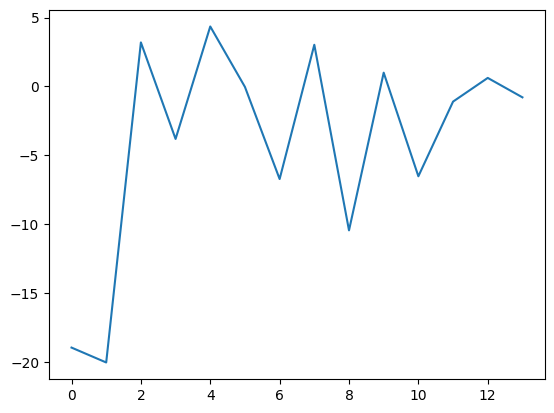

In [74]:
plt.plot(synthesis[0].mfcc)

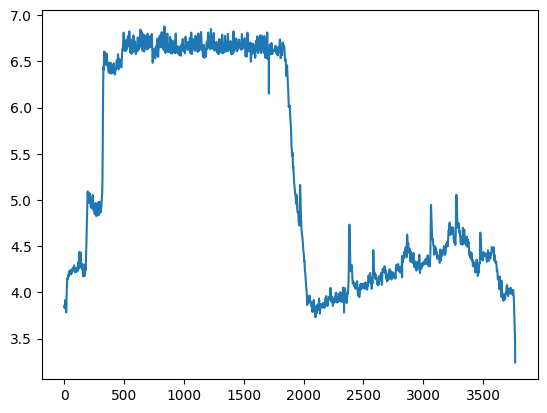

In [51]:
plt.plot(synthesis[0].mcep[:,0])

In [53]:
def moving_average(x, w):
    """ Eats up some samples on the edge """
    return np.convolve(x, np.ones(w), 'valid') / w


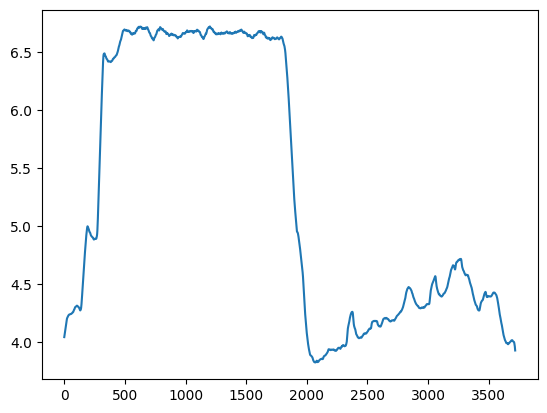

In [57]:
# compute average mel cepstrum of truth vowels
plt.plot(moving_average(synthesis[0].mcep[:,0], 50))

In [70]:
synthesis[0].wav

(44100,
 array([[  1,   1],
        [-34, -41],
        [-50, -59],
        ...,
        [ -5,  -4],
        [ -2,  -3],
        [  1,   1]], dtype=int16))

In [80]:
synthesis[0].wav[1].ndim

2

In [84]:
np.zeros(np.array([[1,2,3],[4,5,6]]).shape)

array([[0., 0., 0.],
       [0., 0., 0.]])